In [83]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import *
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
%matplotlib inline

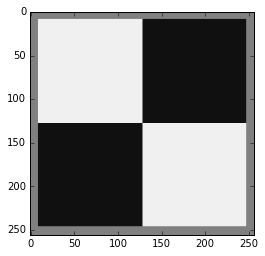

In [84]:
img = cv2.cvtColor(cv2.imread('input/ps1-input0.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

True

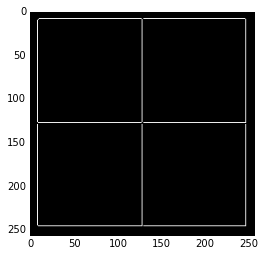

In [85]:
# Question 1.a
img_edges = cv2.Canny(img, 100, 200)
plt.imshow(img_edges, 'gray')
cv2.imwrite('output/ps1-1-a-1.png', img_edges)

In [86]:
# Question 2.a -- Implement Hough transform
def hough_lines_acc(BW, theta_list=None, rho_res=None):
    """
    Returns (H, theta, rho)
    """
    if theta_list is None:
        theta_list = np.linspace(-89, 90, 180)
    if rho_res is None:
        rho_res = 1
    
    if len(BW.shape) == 2:
        height, width = BW.shape
    else:
        height, width, _ = BW.shape

    max_rho = sqrt(height**2 + width**2)
    rho_list = np.array(range(0, ceil(max_rho)+1, rho_res))

    H = np.zeros((len(rho_list), len(theta_list)))
    
    edge_indices = np.nonzero(BW)
    for (row, col) in zip(*edge_indices):
        for theta_idx, theta in enumerate(theta_list):
            rho = col*cos(theta*pi/180) + row*sin(theta*pi/180)

            rho_idx = int(round(rho))
            H[rho_idx, theta_idx] += 1
    
    return (H, theta_list, rho_list)

True

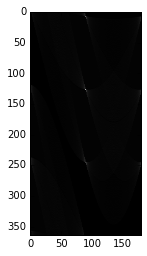

In [87]:
H, theta, rho = hough_lines_acc(img_edges)
Hnorm = H/(np.amax(H)) * 255  # Normalize
plt.imshow(Hnorm, 'gray')

cv2.imwrite('output/ps1-2-a-1.png', Hnorm)

In [112]:
# Question 2.b
def hough_peaks(H, num_peaks = 10, nhood_size = None, threshold = None):
    """
    Find up to top 'num_peaks' peaks in H.
    Only returns peaks above threshold
    
    Returns a 'q' x 2 matrix with coordinates of peaks
    """
    if nhood_size is None:
        nhood_size = list(H.shape)
        nhood_size[0] = ceil(int(nhood_size[0]/50.)) // 2 * 2 + 1
        nhood_size[1] = ceil(int(nhood_size[1]/50.)) // 2 * 2 + 1
        
    if threshold is None:
        threshold = 0.50*np.amax(H)
        
    nhood_filter = np.zeros(nhood_size)
        
    Hc = H.copy()
    peaks = np.empty((num_peaks, 2), dtype=np.uint32)
    last_max = np.inf
    for i in range(num_peaks):
        max_idx = np.argmax(Hc)
        r_idx, c_idx = np.unravel_index([max_idx], Hc.shape)
        
        # Stop if next max value is below threshold
        if Hc[r_idx, c_idx] < threshold:
            break

        peaks[i,:] = [r_idx, c_idx]

        r_offset = -nhood_size[0]//2
        c_offset = -nhood_size[1]//2

        for k1, k2 in np.ndindex(nhood_filter.shape):
            x_idx, y_idx = (r_idx + r_offset + k1, c_idx + c_offset+k2)
            x_idx = min(max(0, x_idx), Hc.shape[0]-1)
            y_idx = min(max(0, y_idx), Hc.shape[1]-1)
            Hc[x_idx, y_idx] = 0
    else:
        # Loop finished
        i = num_peaks
    return peaks[:i,:] # 

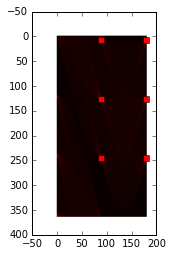

In [89]:
peaks = hough_peaks(H, 10, nhood_size=(51,51))
fig = plt.figure()
plt.imshow(Hnorm, 'hot')
plt.plot(peaks[:,1], peaks[:,0], 'rs')
fig.savefig('ps1-2-b-1.png')

In [116]:
# Question 2.c
def hough_lines_draw(img, outfile, peaks, rho, theta, color = None, thickness = 2, verbose=False):

    if len(img.shape) == 2:
        height, width = img.shape
        img2 = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    else:
        height, width, _ = img.shape
        img2 = img.copy()
        
    if color is None:
        color = (0, 255, 0)
        
    for rho_idx, theta_idx in peaks:
        s_theta = sin(theta[theta_idx]*pi/180.)
        c_theta = cos(theta[theta_idx]*pi/180.)
       
        if abs(theta[theta_idx]) < 1:   # theta = 0 -> normal is along 'x', line is vertical
            pt1 = (0, floor(rho[rho_idx]))
            pt2 = (height, floor(rho[rho_idx]))
        elif abs(theta[theta_idx] == 90):
            pt1 = (floor(rho[rho_idx]), 0)
            pt2 = (floor(rho[rho_idx]), width)
        else:
            m = -c_theta/s_theta   # row -> y, col -> x
            c = rho[rho_idx]/s_theta   # Y intercept
            # y = mx + c
            pt1 = (floor(c), 0)     # Point on Y axis (col = 0 or x = 0)
            pt2 = (0, floor(-c/m))  # Point on X axis (row = 0 or y = 0)
            if c < 0:
                # pt1 and pt2 out of bounds
                # Line will not be in image unless extended
                # Find point at bottom of image (row or y = height)
                pt2 = (height, floor((height - c)/m))
                   
        # Points in cv2.line uses (x, y) coordinates as opposed to row, col
        #   so the coordinates are reversed
        cv2.line(img2, pt1[::-1], pt2[::-1], color, thickness)
        
        if verbose:
            print('Theta : '+str(theta[theta_idx])+', Rho : '+str(rho[rho_idx]))
            print((pt1, pt2))
    cv2.imwrite(outfile, img2)
    return img2

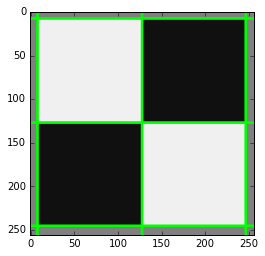

In [91]:
plt.imshow(hough_lines_draw(img, 'output/ps1-2-c-1.png', peaks, rho, theta))

True

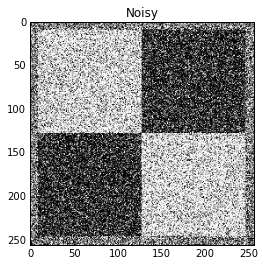

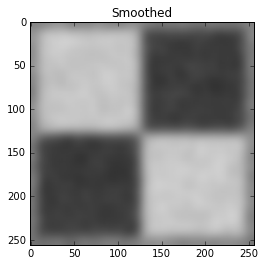

In [92]:
# Question 3.a
img_noisy = cv2.cvtColor(cv2.imread('input/ps1-input0-noise.png'), cv2.COLOR_BGR2RGB)
img_smoothed = cv2.GaussianBlur(img_noisy, (41,41), 0)
plt.figure()
plt.imshow(img_noisy)
plt.title('Noisy')
plt.figure()
plt.imshow(img_smoothed)
plt.title('Smoothed')
cv2.imwrite('output/ps1-3-a-1.png', img_smoothed)

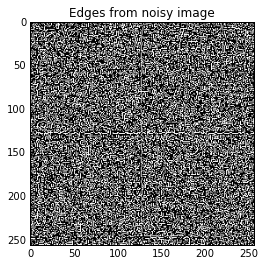

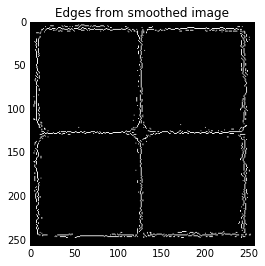

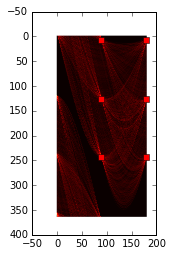

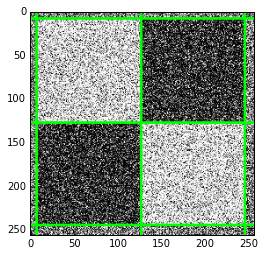

In [93]:
# Question 3.b
edges_noisy = cv2.Canny(img_noisy, 10, 50)
edges_smoothed = cv2.Canny(img_smoothed, 10, 32)
plt.figure()
plt.imshow(edges_noisy, 'gray')
plt.title('Edges from noisy image')
cv2.imwrite('output/ps1-3-b-1.png', edges_noisy)
plt.figure()
plt.imshow(edges_smoothed, 'gray')
plt.title('Edges from smoothed image')
cv2.imwrite('output/ps1-3-b-2.png', edges_smoothed)

# Question 3.c
H, theta, rho = hough_lines_acc(edges_smoothed)
Hnorm = H/(np.amax(H)) * 255  # Normalize
peaks = hough_peaks(H, 6, nhood_size=(21,21))

fig = plt.figure()
plt.imshow(Hnorm, 'hot')
plt.plot(peaks[:,1], peaks[:,0], 'rs')
fig.savefig('ps1-3-c-1.png')

plt.figure()
img_lines = hough_lines_draw(img_noisy, 'output/ps1-3-c-2.png', peaks, rho, theta)
plt.imshow(img_lines)

True

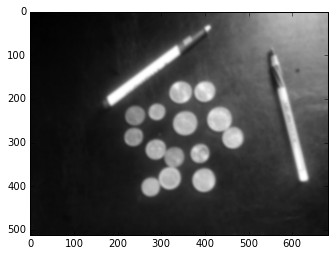

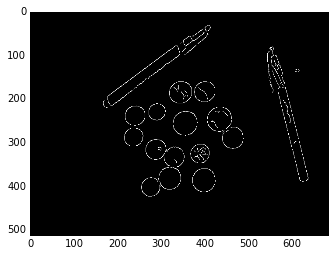

In [102]:
# Question 4.a
img1 = cv2.imread('input/ps1-input1.png')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img1_smooth = cv2.GaussianBlur(img1_gray, (15, 15), 0)
cv2.imwrite('output/ps1-4-a-1.png', img1_smooth)
plt.imshow(img1_smooth, 'gray')

# Question 4.b
plt.figure()
img1_edge = cv2.Canny(img1_smooth, 10, 50)
plt.imshow(img1_edge, 'gray')
cv2.imwrite('output/ps1-4-b-1.png', img1_edge)

5
[[524  75]
 [262 142]
 [505  75]
 [285 142]
 [517  74]]


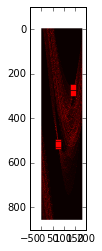

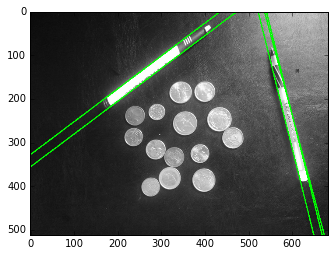

In [106]:
# Question 4.c
H, theta, rho = hough_lines_acc(img1_edge)
Hnorm = H/(np.amax(H)) * 255  # Normalize
peaks = hough_peaks(H, 10, nhood_size=(11,11))
print(peaks)
fig = plt.figure()
plt.imshow(Hnorm, 'hot')
plt.plot(peaks[:,1], peaks[:,0], 'rs')
fig.savefig('ps1-4-c-1.png')

plt.figure()
img1_lines = hough_lines_draw(img1_gray, 'output/ps1-4-c-2.png', peaks, rho, theta)
plt.imshow(img1_lines)

In [ ]:
# Question 5.a -- Hough transform for circles
def hough_circles_acc(img, radius, visualize = False):
    """
    img : Boolean edge image
    radius : Radius of circle to match in pixels 
    
    Returns 'H' accumulator
    """
    H = np.zeros_like(img)
    
    if len(img.shape) == 2:
        height, width = img.shape
    else:
        height, width, _ = img.shape
        
    edge_indices = np.nonzero(img)
    for (row, col) in zip(*edge_indices):
        for theta in np.linspace(-pi, pi, ceil(radius*2*pi)+1):
            # Possible center of circle
            x_c = col + int(round(radius*cos(theta)))
            y_c = row + int(round(radius*sin(theta)))
            if x_c >= 0 and y_c >= 0 and x_c < width and y_c < height:
                H[y_c, x_c] += 1

    if visualize:
        H_norm = H/np.amax(H) * 255
        plt.imshow(H_norm, 'hot')
        
    return H

def find_circles(img, radii, max_count=20):
    """
    Finds upto max_count circles of given radii in image
    
    img   : Boolean edge image
    radii : List of radius values
    
    Returns:
    centers  -> Centers of the circles found
    radii    -> Radii of the circles found (in same order as 'centers')
    """
    out_radii = []
    out_centers =  []
#     out_radii = np.zeros((max_count*len(radii),), dtype=np.uint32)
#     out_centers =  np.zeros((max_count*len(radii),2), dtype=np.uint32)

    ctr = 0
    for radius in radii:
        H = hough_circles_acc(img, radius)
        centers = hough_peaks(H, 10)
        out_centers += [tuple(c) for c in centers]
        out_radii += len(centers)*[radius]
        ctr += len(centers)
        
    return (out_centers, out_radii)

def hough_circles_draw(img, centers, radii, color = None, thickness = 2):
    if len(img.shape) == 2:
        img2 = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    else:
        img2 = img.copy()

    if color is None:
        color = (0, 255, 0)
        
    for center, radius in zip(centers, radii):
        cv2.circle(img2, center[::-1], radius, color, thickness)
    
    return img2

In [ ]:
cv2.imwrite('output/ps1-5-a-1.png', img1_smooth)
cv2.imwrite('output/ps1-5-a-2.png', img1_edge)
centers, radii = find_circles(img1_edge, range(20,27))
img_circ = hough_circles_draw(img1_gray, centers, radii)
cv2.imwrite('output/ps1-5-b-1.png', img_circ)
plt.imshow(img_circ)